## Lección 2. Introducción al aprendizaje de máquina Reducción de la dimensionalidad 

### Modelos de aprendizaje de máquinas Reducción de la dimensionalidad.

##### Abrir en Colab

<a target="_blank" href="https://colab.research.google.com/github/RepoDF/CEFA2025/blob/main/Colab/Lecci%C3%B3n%201%20Introducci%C3%B3n%20al%20Aprendizaje%20de%20M%C3%A1quinas%20Reducci%C3%B3n%20de%20la%20dimensionalidad.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


### Objetivos Notebook Introducción al Aprendizaje de Máquinas Reducción de la dimensionalidad: 

1. Introducir modelos de Reducción de la dimensionalidad aplicada a la gestión de portafolios de portafolios. 

### Ejemplo Factores de riesgo estadísticos

Utilizando los siguientes datos. Encuentre los componentes principales usando los valores propios de la matriz y el método de descomposición de valores singulares y el de Minimum Linear Torsion.

| Nombre       | Descripción                                                                                        |
| ------------ | -------------------------------------------------------------------------------------------------- |
| Cash         | Índice de ICE Tresury Notes & Bills con vencimiento 0-3 meses                                      |
| TIPS         | Bonos del Tesoro de EE. UU. indexados a la inflación (TIPS), 1-5 años​                             |
| Corporativos | Bonos Corporativos con calificación crediticia AAA-A, 1-5 años​                                    |
| Emergentes   | Índice de ICE de Bonos Corporativos de Mercados Emergentes.                                        |
| MBS          | Índice de ICE de títulos respaldados por hipotecas emitidas por Agencias de EE. UU. (Agency MBS)​. |
| Equity       | Índice de retorno total del S&P500                                                                 |

Nota: Para correr este notebook en colab, es nesesario crear una carpeta llamada **datos** y dentro de ella los archivos **"Índices.csv"** y **Yields_2010-2023.csv**. Puede descargarlo del repositorio de GitHub [CEFA 2025 - Repositorio](https://github.com/RepoDF/CEFA2025) o desde el siguiente Drive [CEFA 2025 Datos Notebooks](https://drive.google.com/drive/folders/1JY-Dy7kaSLINKBK4HDOV6fyLKa7R_1Zm?usp=drive_link).


In [30]:
# Instalar las librerías en el entorno de ejecución
%pip install scipy matplotlib pandas numpy scikit-learn

You should consider upgrading via the 'c:\Users\jcamargo\CEFA_2025_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [31]:
# Cargar los datos del S&P 500.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg 
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA


In [32]:

path = os.path.dirname(os.getcwd())

if path == '/': # Si estamos en la raíz del sistema, entonces no es necesario agregar la carpeta datos. (Aplica en Google Colab)
    file_path = os.path.join('datos', 'Índices.csv')
else:
    file_path = os.path.join(path,'datos', 'Índices.csv')
    
    
indices = pd.read_csv(file_path, sep=';', index_col=0, parse_dates=True)

In [33]:
def calculateLogReturns(df): 
    return np.log((df.shift(-1)/df).shift(1))

In [34]:



def torsion(Sigma, Returns, model, method='exact', max_niter=10000, npcomp = 6):
    n = Sigma.shape[0]    
    
    if model == 'PCA':
        eigval, eigvec = linalg.eig(Sigma)
        idx = np.argsort(-eigval) 
        t = eigvec[:,idx]

    elif model == 'PCA-SVD':
        
        
        pca = PCA(n_components=npcomp)
        X = pca.fit_transform(Returns)
        
        eigval, eigvec = pca.explained_variance_, pca.components_ 
        t = eigvec
        
        
    elif model == 'minimum-torsion':
        # C: correlation matrix
        sigma = np.sqrt(np.diag(Sigma))
        C = np.asmatrix(np.diag(1.0/sigma)) * np.asmatrix(Sigma) * np.asmatrix(np.diag(1.0/sigma))
        # Riccati root of correlation matrix
        c = sqrtm(C)
        if method == 'approximate':
            t = (np.asmatrix(sigma) / np.asmatrix(c)) * np.asmatrix(np.diag(1.0/sigma))
        elif method == 'exact':
            # initialize
            d = np.ones((n))
            f = np.zeros((max_niter))
            # iterating
            for i in range(max_niter):
                U = np.asmatrix(np.diag(d)) * c * c * np.asmatrix(np.diag(d))
                u = sqrtm(U)
                q = linalg.inv(u) * np.asmatrix(np.diag(d)) * c
                d = np.diag(q * c)
                pi = np.asmatrix(np.diag(d)) * q
                f[i] = linalg.norm(c - pi, 'fro')
                # if converge
                if i > 0 and abs(f[i]-f[i-1])/f[i] <= 1e-4:
                    f = f[0:i]
                    break
                elif i == max_niter and abs(f[max_niter]-f[max_niter-1])/f[max_niter] >= 1e-4:
                    print('number of max iterations reached: n_iter = ' + str(max_niter))
            x = pi * linalg.inv(np.asmatrix(c))
            t = np.asmatrix(np.diag(sigma)) * x * np.asmatrix(np.diag(1.0/sigma))
    return t

In [35]:
df_returns = calculateLogReturns(indices)
df_returns = df_returns.dropna() 
covariance_matrix = df_returns.cov()
minimum_torsion_matrix = torsion(covariance_matrix, df_returns, "minimum-torsion", method='exact', max_niter=100000)

In [36]:
# Aquí normalizamos los retornos antes de aplicarles el método de PCA.
df_returns = (df_returns - df_returns.mean())/len(df_returns) 

In [37]:
pca_matrix1_m1 = torsion(covariance_matrix, df_returns ,"PCA", method='exact', max_niter=10000, npcomp = 6)
pca_matrix1_m2 = torsion(covariance_matrix, df_returns ,"PCA-SVD", method='exact', max_niter=10000, npcomp = 6)

In [38]:
factor_index = ['Factor'+str(x) for x in range(1, len(df_returns.columns)+1)]
factor_loadings_mlt = pd.DataFrame(minimum_torsion_matrix, columns = covariance_matrix.columns, index =factor_index)
factor_loadings_mlt

,Cash,Tips,Corporativos,MBS,Equity,Emergentes
Factor1,1.000400,-0.001263,0.000340,0.000692,0.000189,0.000894
Factor2,-0.100370,1.170846,-0.319367,-0.143306,-0.002109,-0.093651
Factor3,0.021033,-0.248948,1.337090,-0.256783,0.011673,-0.197684
Factor4,0.096210,-0.250726,-0.576343,1.210565,0.002113,-0.059400
Factor5,0.754040,-0.105646,0.750192,0.060488,1.011917,-0.487969
Factor6,0.118438,-0.156080,-0.422654,-0.056583,-0.016234,1.129318


In [39]:
factor_loadings_pca_m1 = pd.DataFrame(pca_matrix1_m1, columns = covariance_matrix.columns, index = factor_index)
factor_loadings_pca_m2 = pd.DataFrame(pca_matrix1_m2, columns = covariance_matrix.columns, index = factor_index)


El algoritmo de Minimum Linear Torsion desarrollado por Romain Deguest et Al (2013) es un método para obtener factores estadísticos y poder desarrollar aplicaciones de Risk Budgesting o de optimización por Risk Parity. El método obtiene factores ortogonales que son mas intepretables que el modelo de PCA convencional. 

Text(0.5, 1.0, 'Factores de Carga Método MLT')

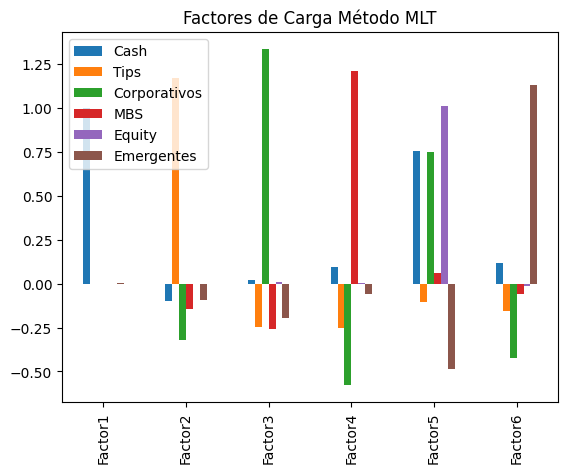

In [40]:
ax = factor_loadings_mlt.plot.bar()
ax.set_title('Factores de Carga Método MLT')

Text(0.5, 1.0, 'Factores de Carga Método PCA')

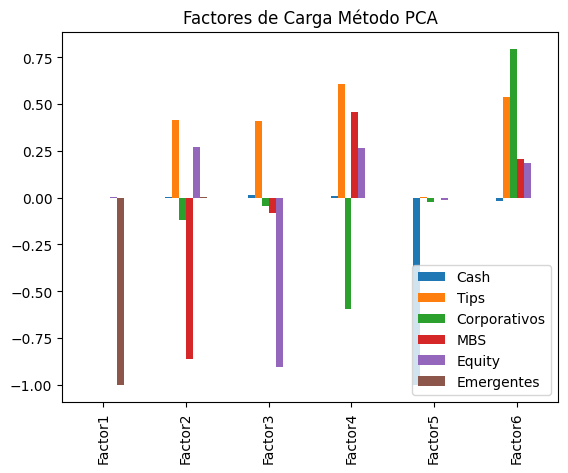

In [41]:
ax = factor_loadings_pca_m1.plot.bar()
ax.set_title('Factores de Carga Método PCA')

Text(0.5, 1.0, 'Factores de Carga Método SVD')

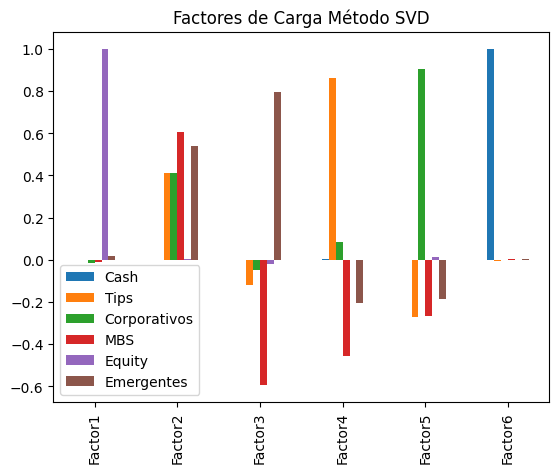

In [42]:
ax = factor_loadings_pca_m2.plot.bar()
ax.set_title('Factores de Carga Método SVD')

### Ejemplo 3: Obtención de Factores de Nivel, Pendiente y Curva con PCA.

Una de las principales aplicaciones de PCA Y de las poco donde guarda interpretabilidad es la de Componentes Principales aplicado a la curva de rendimientos. Al aplicarlo sobre los yields, crea los componentes de nivel, pendiente y curvatura. Antes de examinar la aplicación revisemos un poco algunas características de los datos:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

#yield_df = get_data(start_year=2010,end_year=2023)
#yield_df = yield_df.sort_index()
# yield_df.to_csv('Datos\\'+'Yields_2010-2023.csv')

In [44]:

if path == '/': # Si estamos en la raíz del sistema, entonces no es necesario agregar la carpeta datos. (Aplica en Google Colab)
    file_path = os.path.join('datos', 'Yields_2010-2023.csv')
else:
    file_path = os.path.join(path,'datos', 'Yields_2010-2023.csv')
     
yield_df = pd.read_csv(file_path, sep=',', index_col=0, parse_dates=True)
yield_df


,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,
2010-01-04,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.34,4.67,4.66,4.31,4.09,3.86,3.83,3.75,3.99,3.82
2022-12-27,4.46,4.76,4.75,4.32,4.17,3.94,3.93,3.84,4.10,3.93
2022-12-28,4.46,4.75,4.71,4.31,4.18,3.97,3.97,3.88,4.13,3.98


In [45]:
yield_df.corr() 
### Note que la correlación es mayor cuando el vencimiento de los títulos es similar.

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
3 Mo,1.000000,0.994131,0.978702,0.937747,0.886914,0.739279,0.573964,0.372704,0.159608,0.041155
6 Mo,0.994131,1.000000,0.993947,0.963417,0.917541,0.772179,0.604841,0.396808,0.180160,0.054328
1 Yr,0.978702,0.993947,1.000000,0.984645,0.947210,0.810104,0.643803,0.430585,0.207295,0.075824
2 Yr,0.937747,0.963417,0.984645,1.000000,0.986700,0.884565,0.734420,0.523103,0.292581,0.155754
3 Yr,0.886914,0.917541,0.947210,0.986700,1.000000,0.944759,0.822604,0.625782,0.398156,0.261280
5 Yr,0.739279,0.772179,0.810104,0.884565,0.944759,1.000000,0.961409,0.833804,0.646877,0.528497
7 Yr,0.573964,0.604841,0.643803,0.734420,0.822604,0.961409,1.000000,0.950814,0.823193,0.732256
10 Yr,0.372704,0.396808,0.430585,0.523103,0.625782,0.833804,0.950814,1.000000,0.954687,0.904602
20 Yr,0.159608,0.180160,0.207295,0.292581,0.398156,0.646877,0.823193,0.954687,1.000000,0.980049
30 Yr,0.041155,0.054328,0.075824,0.155754,0.261280,0.528497,0.732256,0.904602,0.980049,1.000000


In [46]:
yield_df.mean()

3 Mo     0.633739
6 Mo     0.727528
1 Yr     0.822801
2 Yr     1.017872
3 Yr     1.212196
5 Yr     1.605953
7 Yr     1.951605
10 Yr    2.255661
20 Yr    2.756839
30 Yr    2.969868
dtype: float64

Se puede notar que efectivamente hay cierta prima termino en promedio a lo largo del tiempo.

In [47]:
yield_df.diff().std()

3 Mo     0.023684
6 Mo     0.022396
1 Yr     0.026216
2 Yr     0.036711
3 Yr     0.042277
5 Yr     0.049538
7 Yr     0.052625
10 Yr    0.051712
20 Yr    0.052232
30 Yr    0.051584
dtype: float64

Se muestra que a mayor plazo mayor desviación estándar.

In [48]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
#Step1: We calculate the mean of the scaled data.
df_normalized_mean = pd.DataFrame(scale(yield_df))
#Step2: Remove any missing data points
df_normalized_mean.dropna(inplace=True)

Text(0.5, 1.0, 'Scree Plot')

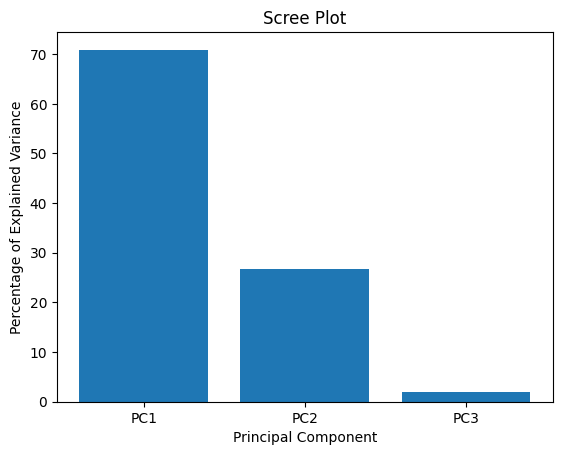

In [49]:

instruments = yield_df.columns
#Step3: We calculate the PCA using fit_transform
components = ['Level', 'Slope', 'Curve']
pca = PCA(n_components=len(components))

YC_PCA = pca.fit_transform(df_normalized_mean)
#Step4: Create a SCREE plot to check the weights of each component
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')


In [50]:
# Los eigenvalores de la matriz.

pca.explained_variance_

array([7.09539945, 2.66649767, 0.20288977])

El 70% de la variación en las tasas se explica por el factor de nivel, el 26.7% por el factor de pendiente, el 2% por el factor de curvatura.

Text(0.5, 1.0, 'Cumulative Explained Variance')

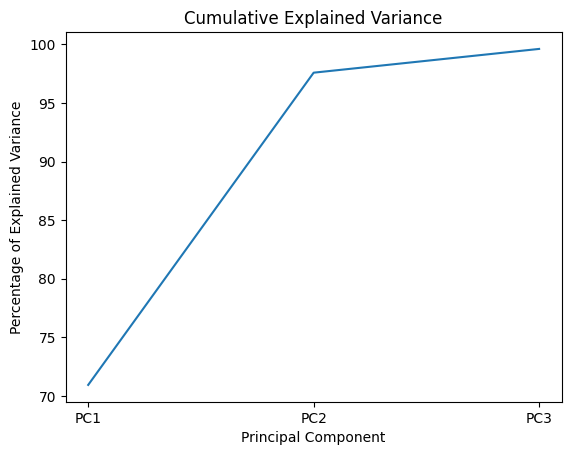

In [51]:
plt.plot(labels, pca.explained_variance_ratio_.cumsum()*100)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Cumulative Explained Variance')

In [52]:
# 
PC1, PC2, PC3 = pca.components_[0],pca.components_[1],pca.components_[2]
NumComponents = 3

topPorfolios = pd.DataFrame(pca.components_[:NumComponents],columns=instruments)
topPorfolios

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,0.315165,0.323955,0.332578,0.348506,0.360440,0.366666,0.346327,0.299477,0.232439,0.188790
1,-0.301796,-0.294470,-0.278497,-0.220085,-0.143287,0.052195,0.215065,0.368222,0.473333,0.516786
2,0.472584,0.341726,0.164091,-0.131361,-0.326244,-0.430281,-0.330774,-0.034096,0.251852,0.387461


(0.0, 0.14)

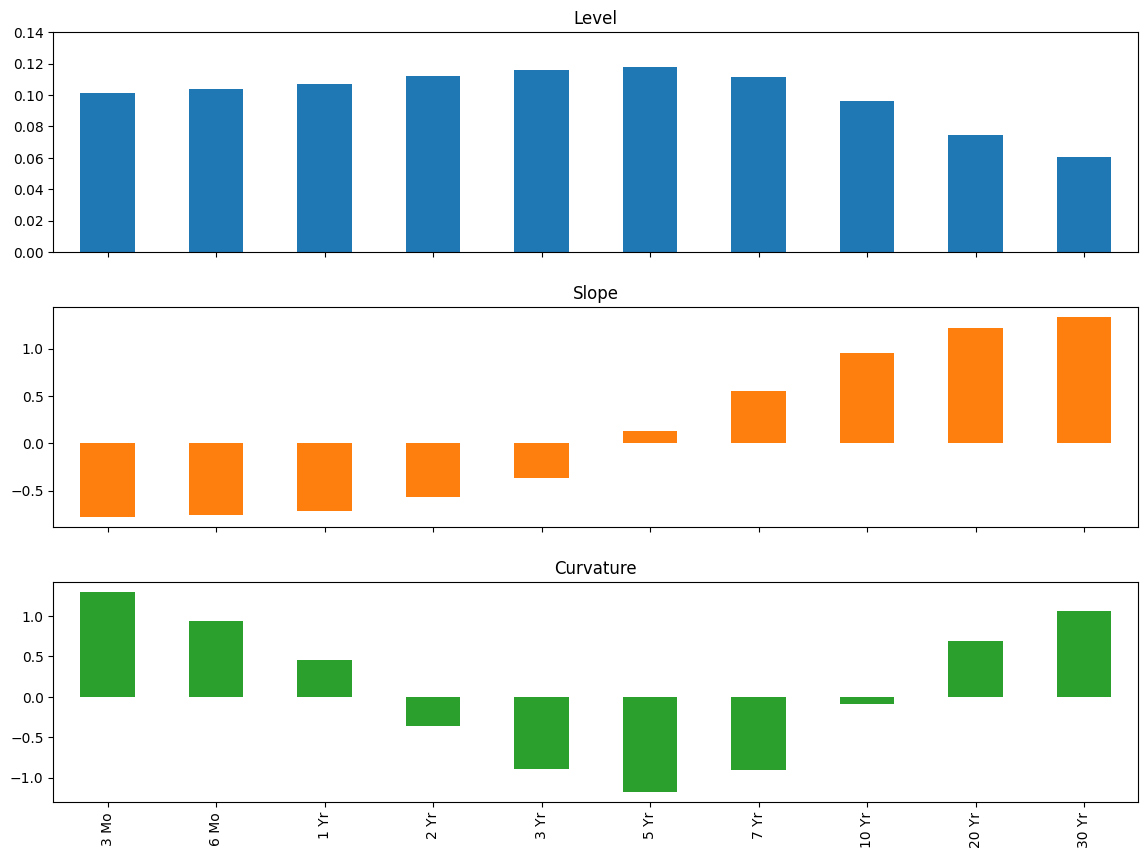

In [53]:

eigenPortfolios = topPorfolios.div(topPorfolios.sum(1),axis=0)
#eigenPortfolios.index = [ f'Portfolio {i}' for i in range(NumComponents)]
eigenPortfolios.index = ['Level', 'Slope', 'Curvature']
axs = eigenPortfolios.T.plot.bar(subplots=True,figsize=(14,10),legend=False)
plt.subplots_adjust(hspace=0.25)
axs[0].set_ylim(0,.14)

In [54]:
yield_df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=3253, freq=None)

In [55]:
YC_PCA

array([[ 2.47936985,  3.8888003 , -0.52414779],
       [ 2.24988572,  3.79228927, -0.45678469],
       [ 2.3774251 ,  3.98572051, -0.44424577],
       ...,
       [ 9.61761008, -1.63887253,  1.09818456],
       [ 9.52151631, -1.74278468,  1.0915898 ],
       [ 9.67153437, -1.66601095,  1.04823676]])

In [56]:
# En el lenguaje de Data Science a estos Factores se les conoce como 'Scores' o PC Scores
orthogonal_factor = pd.DataFrame(YC_PCA, index = yield_df.index[1:], columns = components)
orthogonal_factor 


,Level,Slope,Curve
Date,,,
2010-01-05,2.479370,3.888800,-0.524148
2010-01-06,2.249886,3.792289,-0.456785
2010-01-07,2.377425,3.985721,-0.444246
2010-01-08,2.396440,3.966696,-0.475048
2010-01-11,2.292577,3.985000,-0.413060
...,...,...,...
2022-12-23,9.247949,-1.854960,1.037102
2022-12-27,9.563351,-1.739185,1.111409
2022-12-28,9.617610,-1.638873,1.098185


<Axes: xlabel='Date'>

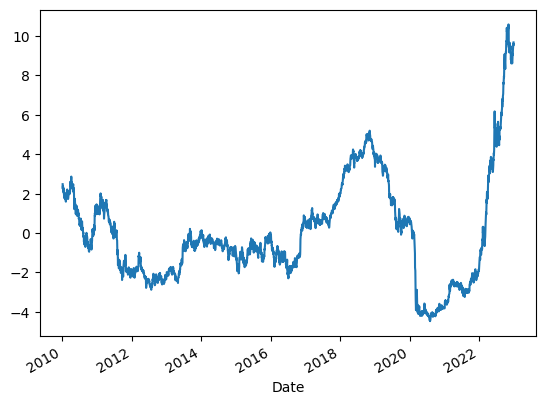

In [57]:
orthogonal_factor = orthogonal_factor.sort_index()
orthogonal_factor['Level'].plot()

<Axes: xlabel='Date'>

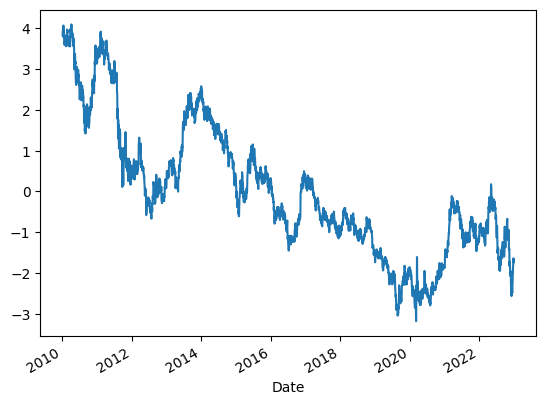

In [58]:
orthogonal_factor['Slope'].plot()

<Axes: xlabel='Date'>

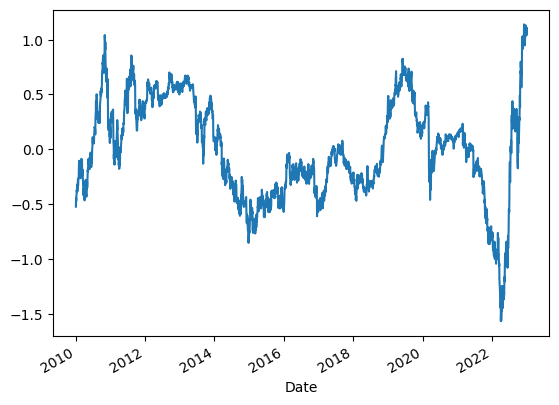

In [59]:
orthogonal_factor['Curve'].plot()

### Referencias 

EDHEC-Risk Institute (2019). Chapter 1.2 – Technical Supplement: Scientific. Lectures Notes for Advances in Asset Allocation Seminar 2020.

EDHEC-Risk Institute (2019). Chapter 1.3 – Technical Supplement: Scientific. Lectures Notes for Advances in Asset Allocation Seminar 2020.